In [8]:
from __future__ import print_function
import cv2
import numpy as np
from PIL import Image, ImageChops
import os, os.path
import scipy
import scipy.misc
import scipy.cluster
#import binascii
import struct
import glob
import imutils
import json
import utils
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from sklearn.cluster import KMeans
from IPython.display import display, HTML
import sys
import pandas as pd
import time
np.set_printoptions(threshold=sys.maxsize)
display(HTML("<style>.container { width:100% !important; }</style>"))

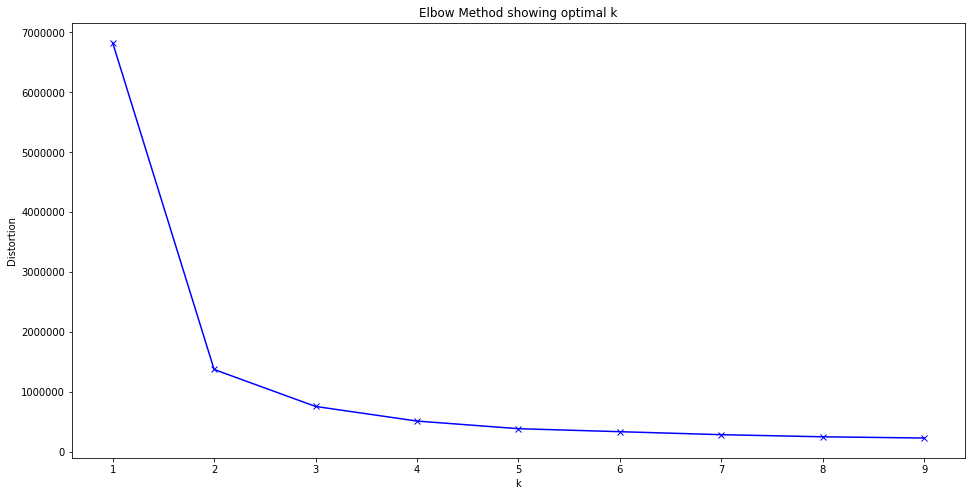

[6828294.848341232, 1375821.8958730157, 758917.7444745097, 515236.76909259224, 387995.22711977025, 337876.846738969, 288074.43404327065, 252754.2169512101, 232081.53303897666]


In [165]:
#Determine optimal k value for clustering using elbow method
distortions = [] #Initialize array with distortions from each clustering run
K = range(1,10) #Explore k values between 1 and 9
#Locate the image to be processed
path2img  =   r'C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 128_BB2_Cropped.jpg'
img = cv2.imread(path2img)
#Run the clustering routine 
for k in K:
    org_img = img.copy()
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    #Remove pure black and green background/field from image prior to clustering 
    green = np.array([60,255,255])
    loGreen = np.array([35,25,25])
    hiGreen = np.array([60,255,255]) 
    mask = cv2.inRange(hsv, loGreen, hiGreen)
    result = img.copy()
    result[mask==255] = (255,255,255)
    result2 = result[np.all(result != 255 , axis=-1)]  #Remove perfectly white pixels/points from array prior to clustering
    #Convert image into a 1D array
    flat_img = np.reshape(result2,(-1,3))
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(flat_img)
    distortions.append(kmeanModel.inertia_)

plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('Elbow Method showing optimal k')
plt.show()

print(distortions)

In [157]:
#Video/Frame Processing section
#Get frame from video
def get_frame(video_file, frame_index):
    """
    Args:
        video_file:     (str) path to .MP4 video file
        frame_index:    (int) query frame index
    Returns:
        frame:          (ndarray, size (y, x, 3)) video frame
                        Uses OpenCV BGR channels
    """

    video_capture = cv2.VideoCapture(video_file)
    video_capture.set(cv2.CAP_PROP_POS_FRAMES, frame_index)
    success, frame = video_capture.read()
    if not success:
        raise ValueError(
            "Couldn't retrieve frame {0} from video {1}".format(
                frame_index,
                video_file
            )
        )

    return frame

#Extract player bounding boxes
def crop_bbox(frame, bbox):
    """
    Args:
        frame:      (ndarray, size (y, x, 3)) video frame
                    Uses OpenCV BGR channels
        bbox:       [u1, v1, u2, v2] integer array of pixel coordinates:
                    (u1, v1) upper-left point of bounding box
                    (u2, v2) lower-right point of bounding box
    Returns:
        bbox_rgb:   (ndarray, size (y, x, 3)) cropped bounding box
                    RGB channels
    """

    bbox_bgr = frame[bbox[1]:bbox[3], bbox[0]:bbox[2], :]
    bbox_rgb  = cv2.cvtColor(bbox_bgr, cv2.COLOR_BGR2RGB)

    return bbox_rgb

#Determine number of frames to iterate over
def count_frames(video_file):
    """
    Args:
        video_file:     (str) path to .MP4 video file
    Returns:
        nFrames:        (int) Number of frames in mp4
    """
    cap = cv2.VideoCapture(video_file)
    length = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    
    return(length)

#Get dictionary from json file                            
def read_json_dict(path2json):
    """
    Args:
        path2json:     (str) path to .MP4 json file containing player bounding boxes
    Returns:
        bb_dict:       (dict) Dictionary containing bounding boxes in each frame
    """
    # Opening JSON file                     
    f = open(path2json)
    
    # Returns JSON object as a dictionary
    bb_dict = json.load(f) 
    
    f.close()
    return(bb_dict)
                           
#Determine number of bounding boxes in frame
def count_bboxes(bb_dict,frame_index):
    """
    Args:
        bb_dict:      (dict) dictionary from json file
        frame:        (int) what frame is being processed
    Returns:
        nDetections:        (int) Number of bounding boxes in frame
    """
    
    bbs = bb_dict['frames'][frame_index]['detections']
    nDetections = len(bbs)
    #print(nDetections, " bounding boxes found in frame ", frame_index)
    return(nDetections)
 
#Extract bounding boxes for a given frame from json
def get_bb4frame(bb_dict,frame_index):
    """
    Args:
        bb_dict:      (dict) dictionary from json file
        frame:        (int) what frame is being processed
    Returns:
        nDetections:        (int) Number of bounding boxes in frame
    """
    
    bbs = bb_dict['frames'][frame_index]['detections']
    #print('These are the coordinates for all bounding boxes in frame', frame_index)
    #print(bbs)
    return(bbs)

#Extract bounding boxes for a given frame from json
def findFirstFrame(bb_dict,frame_index):
    """
    Args:
        bb_dict:      (dict) dictionary from json file
        frame:        (int) what frame is being processed
    Returns:
        firstFrame:        (int) First frame to process in video
    """
    
    firstFrame =  bb_dict['frames'][0]['frame_index']
    print('These is the first frame to process in video ', firstFrame)
    return(firstFrame)

#Extract bounding boxes for a given frame from json
def makeRectangleFromJSON(bb_dict,whichBB):
    """
    Args:
        bb_dict:      (dict) dictionary from json file
        whichBB:        (int) what bounding box is being processed
    Returns:
        x1 ,y1 ,x2 ,y2:    (tuple) tuple containing pixel coordinates for the upper-left and lower-right corners of the bounding box
    """
    x1 ,y1 ,x2 ,y2 = bb_dict[whichBB][0],bb_dict[whichBB][1],bb_dict[whichBB][2],bb_dict[whichBB][3]
    #print(x1 ,y1 ,x2 ,y2, ' These are the coordinates for bounding box ', whichBB)
    return(x1 ,y1 ,x2 ,y2)

def crop_image(image,howMuch):
    """
    Args:
        img        : (array) image of player bounding box
        howMuch    : (int) percent of image to crop (between 0 and 100)
    Returns:
        cropped_img :   (array) cropped image
    """
    val = howMuch/100
    cropped_img = image[0:int(image.shape[0]*val),0:int(image.shape[0])]
    return cropped_img

def rgb2hex(r,g,b):
    return "#{:02x}{:02x}{:02x}".format(r,g,b)

def KMeansTrace(path2img,clusters,whichFrame,whichBB):
    """
    Args:
        path2img   : (str) path to cropped player bounding box
        clusters   : (int) how many clusters to use for KMEANS. (2 and 3 work quite well)
        whichFrame : (int) which frame are we looking at
        whichBB    : (int) which bounding box are we looking at
    Returns:
        hexval :   (string) Hexcode for most dominant color in image. Should be the player jersey color
    """
    img = cv2.imread(path2img)
    org_img = img.copy()
    #print('Org image shape --> ',img.shape)

    #Remove green background/field from image prior to clustering 
    green = np.array([60,255,255]) #This is green in HSV
    loGreen = np.array([30,25,25]) #low green threshold
    hiGreen = np.array([60,255,255]) #Upper green threshold
    #Convert image to HSV
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    mask = cv2.inRange(hsv, loGreen, hiGreen)
    result = img.copy()
    result[mask==255] = (255,255,255)
    result2 = result[np.all(result != 255 , axis=-1)] 
    cv2.imwrite(path2MaskBB + '\\Frame ' + str(whichFrame) + '_BB' + str(whichBB)+ '.jpg', result)

    #Convert image into a 1D array
    flat_img = np.reshape(result2,(-1,3))
    arrayLen = flat_img.shape
    if(arrayLen[0] < clusters):
        img = cv2.imread(path2img)
        flat_img = np.reshape(img,(-1,3))  
        
    #print('After Flattening shape --> ',flat_img.shape)

    #Do the clustering
    kmeans = KMeans(n_clusters=clusters, random_state=0, tol = 1e-4)
    kmeans.fit(flat_img)
    #Define the array with centroids
    dominant_colors = np.array(kmeans.cluster_centers_,dtype='uint')
    #Calculate percentages 
    percentages = (np.unique(kmeans.labels_,return_counts=True)[1])/flat_img.shape[0]
    size = len(percentages)
    #Insufficient clusters generated
    if size < clusters:
    #    print(percentages)
        print('Insufficient clusters generated. Likely due to overmasking. This seems to happen when BB has no player in it (i.e. only field). Clustering without mask')
        img = cv2.imread(path2img)
        flat_img = np.reshape(img,(-1,3))
        #Do the clustering
        kmeans = KMeans(n_clusters=clusters, random_state=0, tol = 1e-6)
        kmeans.fit(flat_img)
        #Define the array with centroids
        dominant_colors = np.array(kmeans.cluster_centers_,dtype='uint')
        #Calculate percentages 
        percentages = (np.unique(kmeans.labels_,return_counts=True)[1])/flat_img.shape[0]
        
    #Combine centroids representing dominant colors and percentages associated with each centroid into an array
    #print(percentages)
    if ((percentages[0] != percentages[1]) & (percentages[0] != percentages[2]) & (percentages[1] != percentages[2])):
        pc = zip(percentages,dominant_colors)
        pc = sorted(pc,reverse=True)
    else:
        pc = list(zip(percentages,dominant_colors))
    
    bgr_val1 = pc[0][1]
    bgr_val2 = pc[1][1]
    bgr_val3 = pc[2][1]
    rgbList1 = [bgr_val1[2], bgr_val1[1], bgr_val1[0]]
    rgbList2 = [bgr_val2[2], bgr_val2[1], bgr_val2[0]]
    rgbList3 = [bgr_val3[2], bgr_val3[1], bgr_val3[0]]
    hexval1 = rgb2hex(bgr_val1[2], bgr_val1[1], bgr_val1[0])
    hexval2 = rgb2hex(bgr_val2[2], bgr_val2[1], bgr_val2[0])
    hexval3 = rgb2hex(bgr_val3[2], bgr_val3[1], bgr_val3[0])
    return hexval1, hexval2, hexval3, rgbList1, rgbList2, rgbList3

def hex_to_rgb(hex_string):
    rgb = colors.hex2color(hex_string)
    return tuple([int(255*x) for x in rgb])
    
#Wrapper function
def getPlayerJerseyColorTrace(path2mp4,path2json,output_loc,nClusters,path2CroppedBB):
    """
    Args:
        path2mp4          : (array) image of player bounding box
        path2json   : (str) directory to save data to
        output_loc   : (int) current frame
        nClusters    : (int) Number of clusters to use for KMEANS
    Returns:
        color_array:   (array) array with dominant color at each bounding box
    """    
    start = time.time()
    #Need to determine starting frame!
    bb_dict = read_json_dict(path2json)
    firstJSONFrame = findFirstFrame(bb_dict,0)
    whichFrame     = firstJSONFrame 
    firstFrame = 0
    howManyFrames = 10
    bbsProcessed = 1
    #2 Count frames in video
    nFrames = int(count_frames(path2mp4)/2)
    print('There are ' + str(nFrames) + ' frames in the video.')
    #Define arrays/lists that will contain output of routine
    jerseyColor1    = [] #This list will contain hexcodes corresponding to dominant color in a bounding box
    jerseyColor2    = [] #This list will contain hexcodes corresponding to 2nd dominant color in a bounding box
    jerseyColor3    = [] #This list will contain hexcodes corresponding to 3rd dominant color in a bounding box
    jerseyColor1RGB = [] #This list will contain hexcodes corresponding to dominant color in a bounding box
    jerseyColor2RGB = [] #This list will contain hexcodes corresponding to 2nd dominant color in a bounding box
    jerseyColor3RGB = [] #This list will contain hexcodes corresponding to 3rd dominant color in a bounding box
    cboxName        = [] #This will contain the file name associated with the bounding being processed
    frameList       = [] #This will contain the frame associated with the bounding box being processed
    bbList          = [] #This will contain the bounding box in the frame being processed
    #nFrames = firstJSONFrame + 6*howManyFrames
    while whichFrame < nFrames:
        #3 Extract the frame
        currentframe = get_frame(path2mp4, whichFrame)
        cv2.imwrite(output_loc + '\\Frame ' + str(whichFrame) + '.jpg', currentframe)
        #Make copy of current frame that will be used to show all bounding boxes in image
        cv2.imwrite(output_loc + '\\Frame ' + str(whichFrame) + '_AllBB.jpg', currentframe)
        #Treat image as cv2 object and determine its size
        image  = cv2.imread(output_loc + '\\Frame ' + str(whichFrame) + '.jpg')
        result = cv2.imread(output_loc + '\\Frame ' + str(whichFrame) + '_AllBB.jpg')

        h1,w1,_ = image.shape
        image = cv2.resize(image, (w1, h1))

        #4 Read the json file --> KEYS = {version,id,frames}
        nbb = count_bboxes(bb_dict,firstFrame) #Number of bounding boxes in current frame
            
        bbs = get_bb4frame(bb_dict,firstFrame) #Bounding box coordinates for current frame

        #4 Draw bounding boxes from json file
        whichBB = 0
        i = 0
        for i in bbs:
            #print('############################################################################################################################################')
            print('######## Processing Frame ' + str(whichFrame) + ' BB ' + str(whichBB) + ' #########')
            #print('############################################################################################################################################')
            #Populate the frame and bounding box lists with current Frame and BB respectively 
            frameList.append(whichFrame)
            bbList.append(whichBB)
            
            x1 ,y1 ,x2 ,y2 = makeRectangleFromJSON(bbs,whichBB)
            #Generate current BB in current frame 
            currentbox = image[y1:y2,x1:x2]
            cv2.imwrite(path2RawBB + '\\Frame ' + str(whichFrame) + '_BB' + str(whichBB)+'.jpg', currentbox)
            
            #Crop image by 50% since we only care about the jersey color
            cropped_bb = currentbox.copy()
            cropped_bb = crop_image(currentbox,40)
            cv2.imwrite(path2CroppedBB + '\\Frame ' + str(whichFrame) + '_BB' + str(whichBB) + '_Cropped.jpg', cropped_bb)  
            
            #Determine player jersey color via kmeans
            path2cbbox = path2CroppedBB + '\\Frame ' + str(whichFrame) + '_BB' + str(whichBB) + '_Cropped.jpg'
            #print('Clustering Initiated...')
            jerseyColorInBB1,jerseyColorInBB2,jerseyColorInBB3, rgbList1, rgbList2, rgbList3 = KMeansTrace(path2cbbox,nClusters,whichFrame,whichBB)
            #print('Clustering Concluded...')
            if (jerseyColorInBB1 != ''):
                jerseyColor1.append(jerseyColorInBB1)
                jerseyColor2.append(jerseyColorInBB2)
                jerseyColor3.append(jerseyColorInBB3)
                jerseyColor1RGB.append(rgbList1)
                jerseyColor2RGB.append(rgbList2)
                jerseyColor3RGB.append(rgbList3)
            else: 
                jerseyColor1.append(None)
                jerseyColor2.append(None)
                jerseyColor3.append(None)
                jerseyColor1RGB.append(None)
                jerseyColor2RGB.append(None)
                jerseyColor3RGB.append(None)
                
            cbox = '\\Frame ' + str(whichFrame) + '_BB' + str(whichBB) + '_Cropped.jpg'
            cboxName.append(path2cbbox)
            
            #Draw ALL rectangles in current frame
            cv2.rectangle(result, (x1, y1),  (x2, y2), (0, 0, 255), 2)
            currentbox = result[y1:y2,x1:x2]
            whichBB += 1
            bbsProcessed += 1
            #Remove background from player bounding box image
            #bb_bg_removed = remove_nonplayer_region(cropped_bb, path2CroppedNoBG, whichFrame, whichBB, threshold1, threshold2, lb1, ub1)
            
        cv2.imwrite(path2Frames + '\\Frame ' + str(whichFrame) + '.jpg', currentframe)   
        cv2.imwrite(path2Frames_wBB + '\\Frame ' + str(whichFrame) + '_AllBB.jpg',result) 
    
        whichFrame += 6
        firstFrame += 1     
    
    print(str(bbsProcessed) + ' Bounding Boxes processed.')
    
    #Turn jerseyColor list into a pandas dataframe
    jerseyColor_df = pd.DataFrame({'File Name': cboxName, 'Jersey Color 1': jerseyColor1, 'Jersey Color 1 RGB ': jerseyColor1RGB, 'Jersey Color 2': jerseyColor2,  'Jersey Color 2 RGB ': jerseyColor2RGB, 'Jersey Color 3': jerseyColor3,  'Jersey Color 3 RGB ': jerseyColor3RGB, 'Frame ID': frameList, 'Bounding Box ID': bbList})
    #Clean up folder
    for zippath in glob.iglob(os.path.join(output_loc, '*.jpg')):
        os.remove(zippath)
    
    end = time.time()
    totTime = end - start
    print(str(totTime) + ' seconds elapsed for process to finish.')
    return jerseyColor_df

#Make image bigger
def makeBigger(img):
 
    #print('Original Dimensions : ',img.shape)
    scale_percent = 200 # percent of original size
    #width = int(img.shape[1] * scale_percent / 100)
    #height = int(img.shape[0] * scale_percent / 100)
    dim = (300, 200) #(width, height)
  
    # resize image
    resized = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)
    return resized

# empty function called when trackbar moves
def emptyFunction():
    pass

#Panel to cycle through player bounding boxes and 2 dominant colors in each BB   
def main(df):
    # blackwindow having 3 color chanels
    windowName ="Open CV Color Palette"
      
    # window name
    cv2.namedWindow(windowName) 
       
    # Define trackbar
    rows = df.shape[0]-1
    cv2.createTrackbar('BB ID', windowName, 0, rows, emptyFunction)
       
    #previousTrackbarValue = -1  # Set this to -1 so the threshold will be applied and the image displayed the first time through the loop
    # Used to open the window until press ESC key
    while(True):
        if cv2.waitKey(1) == 27:
            break
        # Which row to look at in dataframe?
        bbID = cv2.getTrackbarPos('BB ID', windowName)  
        print(bbID)
        fName = df.iloc[bbID]['File Name']
        print(fName)
        bb = cv2.imread(fName)
        bb = makeBigger(bb)
        bbsize = bb.shape
        image1 = np.zeros((bbsize[0], bbsize[1], 3), np.uint8) 
        image2 = np.zeros((bbsize[0], bbsize[1], 3), np.uint8) 
        image3 = np.zeros((bbsize[0], bbsize[1], 3), np.uint8) 
        # values of blue, green, red extracted from the dataframe
        hex_string1 = df.iloc[bbID]['Jersey Color 1']
        hex_string2 = df.iloc[bbID]['Jersey Color 2']
        hex_string3 = df.iloc[bbID]['Jersey Color 3']
        rgb1 = hex_to_rgb(hex_string1)
        blue1  = rgb1[2]
        green1 = rgb1[1]
        red1   = rgb1[0]
        
        rgb2 = hex_to_rgb(hex_string2)
        blue2  = rgb2[2]
        green2 = rgb2[1]
        red2   = rgb2[0]
        
        rgb3 = hex_to_rgb(hex_string3)
        blue3  = rgb3[2]
        green3 = rgb3[1]
        red3   = rgb3[0]
        # font
        font = cv2.FONT_HERSHEY_SIMPLEX  
        # org
        org = (75, 50) 
        # fontScale
        fontScale = 1   
        # Blue color in BGR
        color = (255, 0, 0) 
        # Line thickness of 2 px
        thickness = 2

        image1[:] = [blue1, green1, red1]
        image2[:] = [blue2, green2, red2]
        image3[:] = [blue3, green3, red3]
        # Using cv2.putText() method
        image1 = cv2.putText(image1, hex_string1, org, font, fontScale, color, thickness, cv2.LINE_AA)
        image2 = cv2.putText(image2, hex_string2, org, font, fontScale, color, thickness, cv2.LINE_AA)
        image3 = cv2.putText(image3, hex_string3, org, font, fontScale, color, thickness, cv2.LINE_AA)
        
        # concatenate image Vertically
        verti = np.concatenate((bb, image1, image2, image3), axis=0)
        cv2.imshow(windowName, verti)
        
    cv2.destroyAllWindows()    

In [158]:
path2mp4           =  r'C:\Users\vmurc\Downloads\Downloads\game_1779\LCamera\video_CAMB_CAMCAMBA_20180727_133419_001.mp4'
path2json          =  r'C:\Users\vmurc\Downloads\Downloads\game_1779\object_detector\video_CAMB_CAMCAMBA_20180727_133419_001.MP4.json'
output_loc         =  r'C:\Users\vmurc\Desktop\TraceInterview Project'
path2Frames        =  r'C:\Users\vmurc\Desktop\TraceInterview Project\RawFrames'
path2Frames_wBB    =  r'C:\Users\vmurc\Desktop\TraceInterview Project\Frames_wBBs'
path2RawBB         =  r'C:\Users\vmurc\Desktop\TraceInterview Project\Raw_BB'
path2MaskBB        =  r'C:\Users\vmurc\Desktop\TraceInterview Project\Masked_BB'
path2CroppedBB     =  r'C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB'
path2CroppedNoBG   =  r'C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BG_Removed'
nClusters = 3
jerseyColor3_n = getPlayerJerseyColorTrace(path2mp4,path2json,output_loc,nClusters,path2CroppedBB) 

These is the first frame to process in video  62
There are 3615 frames in the video.
######## Processing Frame 62 BB 0 #########
######## Processing Frame 68 BB 0 #########
######## Processing Frame 68 BB 1 #########
######## Processing Frame 92 BB 0 #########
######## Processing Frame 92 BB 1 #########
######## Processing Frame 98 BB 0 #########
######## Processing Frame 104 BB 0 #########
######## Processing Frame 104 BB 1 #########
######## Processing Frame 110 BB 0 #########
######## Processing Frame 110 BB 1 #########
######## Processing Frame 116 BB 0 #########
######## Processing Frame 116 BB 1 #########
######## Processing Frame 122 BB 0 #########
######## Processing Frame 122 BB 1 #########
######## Processing Frame 128 BB 0 #########
######## Processing Frame 128 BB 1 #########
######## Processing Frame 128 BB 2 #########
######## Processing Frame 134 BB 0 #########
######## Processing Frame 140 BB 0 #########
######## Processing Frame 146 BB 0 #########
######## Processing F

######## Processing Frame 860 BB 0 #########
######## Processing Frame 860 BB 1 #########
######## Processing Frame 860 BB 2 #########
######## Processing Frame 860 BB 3 #########
######## Processing Frame 860 BB 4 #########
######## Processing Frame 866 BB 0 #########
######## Processing Frame 866 BB 1 #########
######## Processing Frame 866 BB 2 #########
######## Processing Frame 866 BB 3 #########
######## Processing Frame 866 BB 4 #########
######## Processing Frame 866 BB 5 #########
######## Processing Frame 866 BB 6 #########
######## Processing Frame 872 BB 0 #########
######## Processing Frame 872 BB 1 #########
######## Processing Frame 872 BB 2 #########
######## Processing Frame 872 BB 3 #########
######## Processing Frame 872 BB 4 #########
######## Processing Frame 872 BB 5 #########
######## Processing Frame 872 BB 6 #########
######## Processing Frame 878 BB 0 #########
######## Processing Frame 878 BB 1 #########
######## Processing Frame 878 BB 2 #########
######## P

######## Processing Frame 956 BB 14 #########
######## Processing Frame 956 BB 15 #########
######## Processing Frame 956 BB 16 #########
######## Processing Frame 956 BB 17 #########
######## Processing Frame 956 BB 18 #########
######## Processing Frame 962 BB 0 #########
######## Processing Frame 962 BB 1 #########
######## Processing Frame 962 BB 2 #########
######## Processing Frame 962 BB 3 #########
######## Processing Frame 962 BB 4 #########
######## Processing Frame 962 BB 5 #########
######## Processing Frame 962 BB 6 #########
######## Processing Frame 962 BB 7 #########
######## Processing Frame 962 BB 8 #########
######## Processing Frame 962 BB 9 #########
######## Processing Frame 962 BB 10 #########
######## Processing Frame 962 BB 11 #########
######## Processing Frame 962 BB 12 #########
######## Processing Frame 962 BB 13 #########
######## Processing Frame 962 BB 14 #########
######## Processing Frame 962 BB 15 #########
######## Processing Frame 962 BB 16 ########

######## Processing Frame 1022 BB 8 #########
######## Processing Frame 1022 BB 9 #########
######## Processing Frame 1022 BB 10 #########
######## Processing Frame 1022 BB 11 #########
######## Processing Frame 1022 BB 12 #########
######## Processing Frame 1022 BB 13 #########
######## Processing Frame 1022 BB 14 #########
######## Processing Frame 1022 BB 15 #########
######## Processing Frame 1022 BB 16 #########
######## Processing Frame 1022 BB 17 #########
######## Processing Frame 1022 BB 18 #########
######## Processing Frame 1028 BB 0 #########
######## Processing Frame 1028 BB 1 #########
######## Processing Frame 1028 BB 2 #########
######## Processing Frame 1028 BB 3 #########
######## Processing Frame 1028 BB 4 #########
######## Processing Frame 1028 BB 5 #########
######## Processing Frame 1028 BB 6 #########
######## Processing Frame 1028 BB 7 #########
######## Processing Frame 1028 BB 8 #########
######## Processing Frame 1028 BB 9 #########
######## Processing Frame

######## Processing Frame 1088 BB 8 #########
######## Processing Frame 1088 BB 9 #########
######## Processing Frame 1088 BB 10 #########
######## Processing Frame 1088 BB 11 #########
######## Processing Frame 1088 BB 12 #########
######## Processing Frame 1094 BB 0 #########
######## Processing Frame 1094 BB 1 #########
######## Processing Frame 1094 BB 2 #########
######## Processing Frame 1094 BB 3 #########
######## Processing Frame 1094 BB 4 #########
######## Processing Frame 1094 BB 5 #########
######## Processing Frame 1094 BB 6 #########
######## Processing Frame 1094 BB 7 #########
######## Processing Frame 1094 BB 8 #########
######## Processing Frame 1094 BB 9 #########
######## Processing Frame 1094 BB 10 #########
######## Processing Frame 1094 BB 11 #########
######## Processing Frame 1094 BB 12 #########
######## Processing Frame 1094 BB 13 #########
######## Processing Frame 1094 BB 14 #########
######## Processing Frame 1094 BB 15 #########
######## Processing Frame

######## Processing Frame 1154 BB 9 #########
######## Processing Frame 1154 BB 10 #########
######## Processing Frame 1154 BB 11 #########
######## Processing Frame 1154 BB 12 #########
######## Processing Frame 1154 BB 13 #########
######## Processing Frame 1154 BB 14 #########
######## Processing Frame 1154 BB 15 #########
######## Processing Frame 1160 BB 0 #########
######## Processing Frame 1160 BB 1 #########
######## Processing Frame 1160 BB 2 #########
######## Processing Frame 1160 BB 3 #########
######## Processing Frame 1160 BB 4 #########
######## Processing Frame 1160 BB 5 #########
######## Processing Frame 1160 BB 6 #########
######## Processing Frame 1160 BB 7 #########
######## Processing Frame 1160 BB 8 #########
######## Processing Frame 1160 BB 9 #########
######## Processing Frame 1160 BB 10 #########
######## Processing Frame 1160 BB 11 #########
######## Processing Frame 1160 BB 12 #########
######## Processing Frame 1160 BB 13 #########
######## Processing Fram

######## Processing Frame 1220 BB 0 #########
######## Processing Frame 1220 BB 1 #########
######## Processing Frame 1220 BB 2 #########
######## Processing Frame 1220 BB 3 #########
######## Processing Frame 1220 BB 4 #########
######## Processing Frame 1220 BB 5 #########
######## Processing Frame 1220 BB 6 #########
######## Processing Frame 1220 BB 7 #########
######## Processing Frame 1220 BB 8 #########
######## Processing Frame 1220 BB 9 #########
######## Processing Frame 1220 BB 10 #########
######## Processing Frame 1220 BB 11 #########
######## Processing Frame 1220 BB 12 #########
######## Processing Frame 1220 BB 13 #########
######## Processing Frame 1226 BB 0 #########
######## Processing Frame 1226 BB 1 #########
######## Processing Frame 1226 BB 2 #########
######## Processing Frame 1226 BB 3 #########
######## Processing Frame 1226 BB 4 #########
######## Processing Frame 1226 BB 5 #########
######## Processing Frame 1226 BB 6 #########
######## Processing Frame 1226

######## Processing Frame 1280 BB 6 #########
######## Processing Frame 1280 BB 7 #########
######## Processing Frame 1280 BB 8 #########
######## Processing Frame 1280 BB 9 #########
######## Processing Frame 1280 BB 10 #########
######## Processing Frame 1280 BB 11 #########
######## Processing Frame 1280 BB 12 #########
######## Processing Frame 1280 BB 13 #########
######## Processing Frame 1280 BB 14 #########
######## Processing Frame 1280 BB 15 #########
######## Processing Frame 1280 BB 16 #########
######## Processing Frame 1280 BB 17 #########
######## Processing Frame 1286 BB 0 #########
######## Processing Frame 1286 BB 1 #########
######## Processing Frame 1286 BB 2 #########
######## Processing Frame 1286 BB 3 #########
######## Processing Frame 1286 BB 4 #########
######## Processing Frame 1286 BB 5 #########
######## Processing Frame 1286 BB 6 #########
######## Processing Frame 1286 BB 7 #########
######## Processing Frame 1286 BB 8 #########
######## Processing Frame 

######## Processing Frame 1490 BB 0 #########
######## Processing Frame 1490 BB 1 #########
######## Processing Frame 1490 BB 2 #########
######## Processing Frame 1490 BB 3 #########
######## Processing Frame 1490 BB 4 #########
######## Processing Frame 1490 BB 5 #########
######## Processing Frame 1490 BB 6 #########
######## Processing Frame 1496 BB 0 #########
######## Processing Frame 1496 BB 1 #########
######## Processing Frame 1496 BB 2 #########
######## Processing Frame 1496 BB 3 #########
######## Processing Frame 1496 BB 4 #########
######## Processing Frame 1496 BB 5 #########
######## Processing Frame 1496 BB 6 #########
######## Processing Frame 1496 BB 7 #########
######## Processing Frame 1502 BB 0 #########
######## Processing Frame 1502 BB 1 #########
######## Processing Frame 1502 BB 2 #########
######## Processing Frame 1502 BB 3 #########
######## Processing Frame 1502 BB 4 #########
######## Processing Frame 1502 BB 5 #########
######## Processing Frame 1502 BB 

######## Processing Frame 1604 BB 9 #########
######## Processing Frame 1610 BB 0 #########
######## Processing Frame 1610 BB 1 #########
######## Processing Frame 1610 BB 2 #########
######## Processing Frame 1610 BB 3 #########
######## Processing Frame 1610 BB 4 #########
######## Processing Frame 1610 BB 5 #########
######## Processing Frame 1610 BB 6 #########
######## Processing Frame 1610 BB 7 #########
######## Processing Frame 1610 BB 8 #########
######## Processing Frame 1610 BB 9 #########
######## Processing Frame 1610 BB 10 #########
######## Processing Frame 1616 BB 0 #########
######## Processing Frame 1616 BB 1 #########
######## Processing Frame 1616 BB 2 #########
######## Processing Frame 1616 BB 3 #########
######## Processing Frame 1616 BB 4 #########
######## Processing Frame 1616 BB 5 #########
######## Processing Frame 1616 BB 6 #########
######## Processing Frame 1616 BB 7 #########
######## Processing Frame 1616 BB 8 #########
######## Processing Frame 1616 BB

######## Processing Frame 1700 BB 9 #########
######## Processing Frame 1700 BB 10 #########
######## Processing Frame 1700 BB 11 #########
######## Processing Frame 1700 BB 12 #########
######## Processing Frame 1700 BB 13 #########
######## Processing Frame 1700 BB 14 #########
######## Processing Frame 1700 BB 15 #########
######## Processing Frame 1706 BB 0 #########
######## Processing Frame 1706 BB 1 #########
######## Processing Frame 1706 BB 2 #########
######## Processing Frame 1706 BB 3 #########
######## Processing Frame 1706 BB 4 #########
######## Processing Frame 1706 BB 5 #########
######## Processing Frame 1706 BB 6 #########
######## Processing Frame 1706 BB 7 #########
######## Processing Frame 1706 BB 8 #########
######## Processing Frame 1706 BB 9 #########
######## Processing Frame 1706 BB 10 #########
######## Processing Frame 1706 BB 11 #########
######## Processing Frame 1712 BB 0 #########
######## Processing Frame 1712 BB 1 #########
######## Processing Frame 

######## Processing Frame 1784 BB 0 #########
######## Processing Frame 1784 BB 1 #########
######## Processing Frame 1784 BB 2 #########
######## Processing Frame 1784 BB 3 #########
######## Processing Frame 1784 BB 4 #########
######## Processing Frame 1784 BB 5 #########
######## Processing Frame 1784 BB 6 #########
######## Processing Frame 1784 BB 7 #########
######## Processing Frame 1784 BB 8 #########
######## Processing Frame 1784 BB 9 #########
######## Processing Frame 1784 BB 10 #########
######## Processing Frame 1790 BB 0 #########
######## Processing Frame 1790 BB 1 #########
######## Processing Frame 1790 BB 2 #########
######## Processing Frame 1790 BB 3 #########
######## Processing Frame 1790 BB 4 #########
######## Processing Frame 1790 BB 5 #########
######## Processing Frame 1790 BB 6 #########
######## Processing Frame 1790 BB 7 #########
######## Processing Frame 1790 BB 8 #########
######## Processing Frame 1790 BB 9 #########
######## Processing Frame 1790 BB

######## Processing Frame 1850 BB 15 #########
######## Processing Frame 1856 BB 0 #########
######## Processing Frame 1856 BB 1 #########
######## Processing Frame 1856 BB 2 #########
######## Processing Frame 1856 BB 3 #########
######## Processing Frame 1856 BB 4 #########
######## Processing Frame 1856 BB 5 #########
######## Processing Frame 1856 BB 6 #########
######## Processing Frame 1856 BB 7 #########
######## Processing Frame 1856 BB 8 #########
######## Processing Frame 1856 BB 9 #########
######## Processing Frame 1856 BB 10 #########
######## Processing Frame 1856 BB 11 #########
######## Processing Frame 1856 BB 12 #########
######## Processing Frame 1856 BB 13 #########
######## Processing Frame 1856 BB 14 #########
######## Processing Frame 1856 BB 15 #########
######## Processing Frame 1862 BB 0 #########
######## Processing Frame 1862 BB 1 #########
######## Processing Frame 1862 BB 2 #########
######## Processing Frame 1862 BB 3 #########
######## Processing Frame 1

######## Processing Frame 1934 BB 0 #########
######## Processing Frame 1934 BB 1 #########
######## Processing Frame 1934 BB 2 #########
######## Processing Frame 1934 BB 3 #########
######## Processing Frame 1934 BB 4 #########
######## Processing Frame 1934 BB 5 #########
######## Processing Frame 1934 BB 6 #########
######## Processing Frame 1934 BB 7 #########
######## Processing Frame 1934 BB 8 #########
######## Processing Frame 1934 BB 9 #########
######## Processing Frame 1934 BB 10 #########
######## Processing Frame 1934 BB 11 #########
######## Processing Frame 1934 BB 12 #########
######## Processing Frame 1934 BB 13 #########
######## Processing Frame 1934 BB 14 #########
######## Processing Frame 1940 BB 0 #########
######## Processing Frame 1940 BB 1 #########
######## Processing Frame 1940 BB 2 #########
######## Processing Frame 1940 BB 3 #########
######## Processing Frame 1940 BB 4 #########
######## Processing Frame 1940 BB 5 #########
######## Processing Frame 194

######## Processing Frame 2000 BB 7 #########
######## Processing Frame 2000 BB 8 #########
######## Processing Frame 2000 BB 9 #########
######## Processing Frame 2000 BB 10 #########
######## Processing Frame 2000 BB 11 #########
######## Processing Frame 2000 BB 12 #########
######## Processing Frame 2000 BB 13 #########
######## Processing Frame 2000 BB 14 #########
######## Processing Frame 2006 BB 0 #########
######## Processing Frame 2006 BB 1 #########
######## Processing Frame 2006 BB 2 #########
######## Processing Frame 2006 BB 3 #########
######## Processing Frame 2006 BB 4 #########
######## Processing Frame 2006 BB 5 #########
######## Processing Frame 2006 BB 6 #########
######## Processing Frame 2006 BB 7 #########
######## Processing Frame 2006 BB 8 #########
######## Processing Frame 2006 BB 9 #########
######## Processing Frame 2006 BB 10 #########
######## Processing Frame 2006 BB 11 #########
######## Processing Frame 2006 BB 12 #########
######## Processing Frame 

######## Processing Frame 2072 BB 8 #########
######## Processing Frame 2072 BB 9 #########
######## Processing Frame 2072 BB 10 #########
######## Processing Frame 2072 BB 11 #########
######## Processing Frame 2072 BB 12 #########
######## Processing Frame 2078 BB 0 #########
######## Processing Frame 2078 BB 1 #########
######## Processing Frame 2078 BB 2 #########
######## Processing Frame 2078 BB 3 #########
######## Processing Frame 2078 BB 4 #########
######## Processing Frame 2078 BB 5 #########
######## Processing Frame 2078 BB 6 #########
######## Processing Frame 2078 BB 7 #########
######## Processing Frame 2078 BB 8 #########
######## Processing Frame 2078 BB 9 #########
######## Processing Frame 2078 BB 10 #########
######## Processing Frame 2078 BB 11 #########
######## Processing Frame 2078 BB 12 #########
######## Processing Frame 2078 BB 13 #########
######## Processing Frame 2084 BB 0 #########
######## Processing Frame 2084 BB 1 #########
######## Processing Frame 2

######## Processing Frame 2156 BB 7 #########
######## Processing Frame 2156 BB 8 #########
######## Processing Frame 2156 BB 9 #########
######## Processing Frame 2156 BB 10 #########
######## Processing Frame 2156 BB 11 #########
######## Processing Frame 2156 BB 12 #########
######## Processing Frame 2156 BB 13 #########
######## Processing Frame 2156 BB 14 #########
######## Processing Frame 2162 BB 0 #########
######## Processing Frame 2162 BB 1 #########
######## Processing Frame 2162 BB 2 #########
######## Processing Frame 2162 BB 3 #########
######## Processing Frame 2162 BB 4 #########
######## Processing Frame 2162 BB 5 #########
######## Processing Frame 2162 BB 6 #########
######## Processing Frame 2162 BB 7 #########
######## Processing Frame 2162 BB 8 #########
######## Processing Frame 2162 BB 9 #########
######## Processing Frame 2162 BB 10 #########
######## Processing Frame 2162 BB 11 #########
######## Processing Frame 2162 BB 12 #########
######## Processing Frame 

######## Processing Frame 2234 BB 0 #########
######## Processing Frame 2234 BB 1 #########
######## Processing Frame 2234 BB 2 #########
######## Processing Frame 2234 BB 3 #########
######## Processing Frame 2234 BB 4 #########
######## Processing Frame 2234 BB 5 #########
######## Processing Frame 2234 BB 6 #########
######## Processing Frame 2234 BB 7 #########
######## Processing Frame 2234 BB 8 #########
######## Processing Frame 2234 BB 9 #########
######## Processing Frame 2234 BB 10 #########
######## Processing Frame 2234 BB 11 #########
######## Processing Frame 2240 BB 0 #########
######## Processing Frame 2240 BB 1 #########
######## Processing Frame 2240 BB 2 #########
######## Processing Frame 2240 BB 3 #########
######## Processing Frame 2240 BB 4 #########
######## Processing Frame 2240 BB 5 #########
######## Processing Frame 2240 BB 6 #########
######## Processing Frame 2240 BB 7 #########
######## Processing Frame 2240 BB 8 #########
######## Processing Frame 2240 B

######## Processing Frame 2330 BB 8 #########
######## Processing Frame 2330 BB 9 #########
######## Processing Frame 2336 BB 0 #########
######## Processing Frame 2336 BB 1 #########
######## Processing Frame 2336 BB 2 #########
######## Processing Frame 2336 BB 3 #########
######## Processing Frame 2336 BB 4 #########
######## Processing Frame 2336 BB 5 #########
######## Processing Frame 2336 BB 6 #########
######## Processing Frame 2336 BB 7 #########
######## Processing Frame 2336 BB 8 #########
######## Processing Frame 2336 BB 9 #########
######## Processing Frame 2342 BB 0 #########
######## Processing Frame 2342 BB 1 #########
######## Processing Frame 2342 BB 2 #########
######## Processing Frame 2342 BB 3 #########
######## Processing Frame 2342 BB 4 #########
######## Processing Frame 2342 BB 5 #########
######## Processing Frame 2342 BB 6 #########
######## Processing Frame 2342 BB 7 #########
######## Processing Frame 2342 BB 8 #########
######## Processing Frame 2342 BB 

######## Processing Frame 2480 BB 0 #########
######## Processing Frame 2480 BB 1 #########
######## Processing Frame 2480 BB 2 #########
######## Processing Frame 2480 BB 3 #########
######## Processing Frame 2480 BB 4 #########
######## Processing Frame 2480 BB 5 #########
######## Processing Frame 2480 BB 6 #########
######## Processing Frame 2486 BB 0 #########
######## Processing Frame 2486 BB 1 #########
######## Processing Frame 2486 BB 2 #########
######## Processing Frame 2486 BB 3 #########
######## Processing Frame 2486 BB 4 #########
######## Processing Frame 2486 BB 5 #########
######## Processing Frame 2492 BB 0 #########
######## Processing Frame 2492 BB 1 #########
######## Processing Frame 2492 BB 2 #########
######## Processing Frame 2492 BB 3 #########
######## Processing Frame 2492 BB 4 #########
######## Processing Frame 2492 BB 5 #########
######## Processing Frame 2492 BB 6 #########
######## Processing Frame 2498 BB 0 #########
######## Processing Frame 2498 BB 

######## Processing Frame 2588 BB 14 #########
######## Processing Frame 2594 BB 0 #########
######## Processing Frame 2594 BB 1 #########
######## Processing Frame 2594 BB 2 #########
######## Processing Frame 2594 BB 3 #########
######## Processing Frame 2594 BB 4 #########
######## Processing Frame 2594 BB 5 #########
######## Processing Frame 2594 BB 6 #########
######## Processing Frame 2594 BB 7 #########
######## Processing Frame 2594 BB 8 #########
######## Processing Frame 2594 BB 9 #########
######## Processing Frame 2594 BB 10 #########
######## Processing Frame 2594 BB 11 #########
######## Processing Frame 2594 BB 12 #########
######## Processing Frame 2600 BB 0 #########
######## Processing Frame 2600 BB 1 #########
######## Processing Frame 2600 BB 2 #########
######## Processing Frame 2600 BB 3 #########
######## Processing Frame 2600 BB 4 #########
######## Processing Frame 2600 BB 5 #########
######## Processing Frame 2600 BB 6 #########
######## Processing Frame 2600

######## Processing Frame 2672 BB 0 #########
######## Processing Frame 2672 BB 1 #########
######## Processing Frame 2672 BB 2 #########
######## Processing Frame 2672 BB 3 #########
######## Processing Frame 2672 BB 4 #########
######## Processing Frame 2672 BB 5 #########
######## Processing Frame 2672 BB 6 #########
######## Processing Frame 2672 BB 7 #########
######## Processing Frame 2672 BB 8 #########
######## Processing Frame 2672 BB 9 #########
######## Processing Frame 2672 BB 10 #########
######## Processing Frame 2672 BB 11 #########
######## Processing Frame 2672 BB 12 #########
######## Processing Frame 2672 BB 13 #########
######## Processing Frame 2672 BB 14 #########
######## Processing Frame 2678 BB 0 #########
######## Processing Frame 2678 BB 1 #########
######## Processing Frame 2678 BB 2 #########
######## Processing Frame 2678 BB 3 #########
######## Processing Frame 2678 BB 4 #########
######## Processing Frame 2678 BB 5 #########
######## Processing Frame 267

######## Processing Frame 2750 BB 9 #########
######## Processing Frame 2750 BB 10 #########
######## Processing Frame 2756 BB 0 #########
######## Processing Frame 2756 BB 1 #########
######## Processing Frame 2756 BB 2 #########
######## Processing Frame 2756 BB 3 #########
######## Processing Frame 2756 BB 4 #########
######## Processing Frame 2756 BB 5 #########
######## Processing Frame 2756 BB 6 #########
######## Processing Frame 2756 BB 7 #########
######## Processing Frame 2756 BB 8 #########
######## Processing Frame 2756 BB 9 #########
######## Processing Frame 2756 BB 10 #########
######## Processing Frame 2756 BB 11 #########
######## Processing Frame 2762 BB 0 #########
######## Processing Frame 2762 BB 1 #########
######## Processing Frame 2762 BB 2 #########
######## Processing Frame 2762 BB 3 #########
######## Processing Frame 2762 BB 4 #########
######## Processing Frame 2762 BB 5 #########
######## Processing Frame 2762 BB 6 #########
######## Processing Frame 2762 

######## Processing Frame 2852 BB 0 #########
######## Processing Frame 2852 BB 1 #########
######## Processing Frame 2852 BB 2 #########
######## Processing Frame 2852 BB 3 #########
######## Processing Frame 2852 BB 4 #########
######## Processing Frame 2852 BB 5 #########
######## Processing Frame 2852 BB 6 #########
######## Processing Frame 2852 BB 7 #########
######## Processing Frame 2852 BB 8 #########
######## Processing Frame 2852 BB 9 #########
######## Processing Frame 2852 BB 10 #########
######## Processing Frame 2852 BB 11 #########
######## Processing Frame 2852 BB 12 #########
######## Processing Frame 2858 BB 0 #########
######## Processing Frame 2858 BB 1 #########
######## Processing Frame 2858 BB 2 #########
######## Processing Frame 2858 BB 3 #########
######## Processing Frame 2858 BB 4 #########
######## Processing Frame 2858 BB 5 #########
######## Processing Frame 2858 BB 6 #########
######## Processing Frame 2858 BB 7 #########
######## Processing Frame 2858 

######## Processing Frame 2942 BB 0 #########
######## Processing Frame 2942 BB 1 #########
######## Processing Frame 2942 BB 2 #########
######## Processing Frame 2942 BB 3 #########
######## Processing Frame 2942 BB 4 #########
######## Processing Frame 2942 BB 5 #########
######## Processing Frame 2942 BB 6 #########
######## Processing Frame 2942 BB 7 #########
######## Processing Frame 2942 BB 8 #########
######## Processing Frame 2942 BB 9 #########
######## Processing Frame 2942 BB 10 #########
######## Processing Frame 2948 BB 0 #########
######## Processing Frame 2948 BB 1 #########
######## Processing Frame 2948 BB 2 #########
######## Processing Frame 2948 BB 3 #########
######## Processing Frame 2948 BB 4 #########
######## Processing Frame 2948 BB 5 #########
######## Processing Frame 2948 BB 6 #########
######## Processing Frame 2948 BB 7 #########
######## Processing Frame 2948 BB 8 #########
######## Processing Frame 2948 BB 9 #########
######## Processing Frame 2948 BB

######## Processing Frame 3044 BB 0 #########
######## Processing Frame 3044 BB 1 #########
######## Processing Frame 3044 BB 2 #########
######## Processing Frame 3044 BB 3 #########
######## Processing Frame 3044 BB 4 #########
######## Processing Frame 3044 BB 5 #########
######## Processing Frame 3044 BB 6 #########
######## Processing Frame 3044 BB 7 #########
######## Processing Frame 3044 BB 8 #########
######## Processing Frame 3044 BB 9 #########
######## Processing Frame 3050 BB 0 #########
######## Processing Frame 3050 BB 1 #########
######## Processing Frame 3050 BB 2 #########
######## Processing Frame 3050 BB 3 #########
######## Processing Frame 3050 BB 4 #########
######## Processing Frame 3050 BB 5 #########
######## Processing Frame 3050 BB 6 #########
######## Processing Frame 3050 BB 7 #########
######## Processing Frame 3050 BB 8 #########
######## Processing Frame 3056 BB 0 #########
######## Processing Frame 3056 BB 1 #########
######## Processing Frame 3056 BB 

######## Processing Frame 3134 BB 7 #########
######## Processing Frame 3134 BB 8 #########
######## Processing Frame 3134 BB 9 #########
######## Processing Frame 3134 BB 10 #########
######## Processing Frame 3134 BB 11 #########
######## Processing Frame 3134 BB 12 #########
######## Processing Frame 3134 BB 13 #########
######## Processing Frame 3134 BB 14 #########
######## Processing Frame 3140 BB 0 #########
######## Processing Frame 3140 BB 1 #########
######## Processing Frame 3140 BB 2 #########
######## Processing Frame 3140 BB 3 #########
######## Processing Frame 3140 BB 4 #########
######## Processing Frame 3140 BB 5 #########
######## Processing Frame 3140 BB 6 #########
######## Processing Frame 3140 BB 7 #########
######## Processing Frame 3140 BB 8 #########
######## Processing Frame 3140 BB 9 #########
######## Processing Frame 3140 BB 10 #########
######## Processing Frame 3140 BB 11 #########
######## Processing Frame 3140 BB 12 #########
######## Processing Frame 

######## Processing Frame 3200 BB 14 #########
######## Processing Frame 3200 BB 15 #########
######## Processing Frame 3206 BB 0 #########
######## Processing Frame 3206 BB 1 #########
######## Processing Frame 3206 BB 2 #########
######## Processing Frame 3206 BB 3 #########
######## Processing Frame 3206 BB 4 #########
######## Processing Frame 3206 BB 5 #########
######## Processing Frame 3206 BB 6 #########
######## Processing Frame 3206 BB 7 #########
######## Processing Frame 3206 BB 8 #########
######## Processing Frame 3206 BB 9 #########
######## Processing Frame 3206 BB 10 #########
######## Processing Frame 3206 BB 11 #########
######## Processing Frame 3206 BB 12 #########
######## Processing Frame 3206 BB 13 #########
######## Processing Frame 3206 BB 14 #########
######## Processing Frame 3206 BB 15 #########
######## Processing Frame 3206 BB 16 #########
######## Processing Frame 3212 BB 0 #########
######## Processing Frame 3212 BB 1 #########
######## Processing Frame

######## Processing Frame 3266 BB 0 #########
######## Processing Frame 3266 BB 1 #########
######## Processing Frame 3266 BB 2 #########
######## Processing Frame 3266 BB 3 #########
######## Processing Frame 3266 BB 4 #########
######## Processing Frame 3266 BB 5 #########
######## Processing Frame 3266 BB 6 #########
######## Processing Frame 3266 BB 7 #########
######## Processing Frame 3266 BB 8 #########
######## Processing Frame 3266 BB 9 #########
######## Processing Frame 3266 BB 10 #########
######## Processing Frame 3266 BB 11 #########
######## Processing Frame 3266 BB 12 #########
######## Processing Frame 3266 BB 13 #########
######## Processing Frame 3266 BB 14 #########
######## Processing Frame 3266 BB 15 #########
######## Processing Frame 3266 BB 16 #########
######## Processing Frame 3266 BB 17 #########
######## Processing Frame 3272 BB 0 #########
######## Processing Frame 3272 BB 1 #########
######## Processing Frame 3272 BB 2 #########
######## Processing Frame 

######## Processing Frame 3314 BB 16 #########
######## Processing Frame 3314 BB 17 #########
######## Processing Frame 3314 BB 18 #########
######## Processing Frame 3314 BB 19 #########
######## Processing Frame 3314 BB 20 #########
######## Processing Frame 3314 BB 21 #########
######## Processing Frame 3314 BB 22 #########
######## Processing Frame 3320 BB 0 #########
######## Processing Frame 3320 BB 1 #########
######## Processing Frame 3320 BB 2 #########
######## Processing Frame 3320 BB 3 #########
######## Processing Frame 3320 BB 4 #########
######## Processing Frame 3320 BB 5 #########
######## Processing Frame 3320 BB 6 #########
######## Processing Frame 3320 BB 7 #########
######## Processing Frame 3320 BB 8 #########
######## Processing Frame 3320 BB 9 #########
######## Processing Frame 3320 BB 10 #########
######## Processing Frame 3320 BB 11 #########
######## Processing Frame 3320 BB 12 #########
######## Processing Frame 3320 BB 13 #########
######## Processing Fra

######## Processing Frame 3368 BB 7 #########
######## Processing Frame 3368 BB 8 #########
######## Processing Frame 3368 BB 9 #########
######## Processing Frame 3368 BB 10 #########
######## Processing Frame 3368 BB 11 #########
######## Processing Frame 3368 BB 12 #########
######## Processing Frame 3368 BB 13 #########
######## Processing Frame 3368 BB 14 #########
######## Processing Frame 3368 BB 15 #########
######## Processing Frame 3368 BB 16 #########
######## Processing Frame 3368 BB 17 #########
######## Processing Frame 3368 BB 18 #########
######## Processing Frame 3368 BB 19 #########
######## Processing Frame 3368 BB 20 #########
######## Processing Frame 3368 BB 21 #########
######## Processing Frame 3374 BB 0 #########
######## Processing Frame 3374 BB 1 #########
######## Processing Frame 3374 BB 2 #########
######## Processing Frame 3374 BB 3 #########
######## Processing Frame 3374 BB 4 #########
######## Processing Frame 3374 BB 5 #########
######## Processing Fr

######## Processing Frame 3416 BB 0 #########
######## Processing Frame 3416 BB 1 #########
######## Processing Frame 3416 BB 2 #########
######## Processing Frame 3416 BB 3 #########
######## Processing Frame 3416 BB 4 #########
######## Processing Frame 3416 BB 5 #########
######## Processing Frame 3416 BB 6 #########
######## Processing Frame 3416 BB 7 #########
######## Processing Frame 3416 BB 8 #########
######## Processing Frame 3416 BB 9 #########
######## Processing Frame 3416 BB 10 #########
######## Processing Frame 3416 BB 11 #########
######## Processing Frame 3416 BB 12 #########
######## Processing Frame 3416 BB 13 #########
######## Processing Frame 3416 BB 14 #########
######## Processing Frame 3416 BB 15 #########
######## Processing Frame 3416 BB 16 #########
######## Processing Frame 3416 BB 17 #########
######## Processing Frame 3416 BB 18 #########
######## Processing Frame 3416 BB 19 #########
######## Processing Frame 3416 BB 20 #########
######## Processing Fra

######## Processing Frame 3458 BB 15 #########
######## Processing Frame 3458 BB 16 #########
######## Processing Frame 3458 BB 17 #########
######## Processing Frame 3458 BB 18 #########
######## Processing Frame 3458 BB 19 #########
######## Processing Frame 3458 BB 20 #########
######## Processing Frame 3458 BB 21 #########
######## Processing Frame 3458 BB 22 #########
######## Processing Frame 3458 BB 23 #########
######## Processing Frame 3458 BB 24 #########
######## Processing Frame 3458 BB 25 #########
######## Processing Frame 3458 BB 26 #########
######## Processing Frame 3464 BB 0 #########
######## Processing Frame 3464 BB 1 #########
######## Processing Frame 3464 BB 2 #########
######## Processing Frame 3464 BB 3 #########
######## Processing Frame 3464 BB 4 #########
######## Processing Frame 3464 BB 5 #########
######## Processing Frame 3464 BB 6 #########
######## Processing Frame 3464 BB 7 #########
######## Processing Frame 3464 BB 8 #########
######## Processing Fr

######## Processing Frame 3506 BB 17 #########
######## Processing Frame 3506 BB 18 #########
######## Processing Frame 3506 BB 19 #########
######## Processing Frame 3506 BB 20 #########
######## Processing Frame 3506 BB 21 #########
######## Processing Frame 3506 BB 22 #########
######## Processing Frame 3506 BB 23 #########
######## Processing Frame 3506 BB 24 #########
######## Processing Frame 3512 BB 0 #########
######## Processing Frame 3512 BB 1 #########
######## Processing Frame 3512 BB 2 #########
######## Processing Frame 3512 BB 3 #########
######## Processing Frame 3512 BB 4 #########
######## Processing Frame 3512 BB 5 #########
######## Processing Frame 3512 BB 6 #########
######## Processing Frame 3512 BB 7 #########
######## Processing Frame 3512 BB 8 #########
######## Processing Frame 3512 BB 9 #########
######## Processing Frame 3512 BB 10 #########
######## Processing Frame 3512 BB 11 #########
######## Processing Frame 3512 BB 12 #########
######## Processing Fra

######## Processing Frame 3554 BB 9 #########
######## Processing Frame 3554 BB 10 #########
######## Processing Frame 3554 BB 11 #########
######## Processing Frame 3554 BB 12 #########
######## Processing Frame 3554 BB 13 #########
######## Processing Frame 3554 BB 14 #########
######## Processing Frame 3554 BB 15 #########
######## Processing Frame 3554 BB 16 #########
######## Processing Frame 3554 BB 17 #########
######## Processing Frame 3554 BB 18 #########
######## Processing Frame 3554 BB 19 #########
######## Processing Frame 3554 BB 20 #########
######## Processing Frame 3554 BB 21 #########
######## Processing Frame 3554 BB 22 #########
######## Processing Frame 3560 BB 0 #########
######## Processing Frame 3560 BB 1 #########
######## Processing Frame 3560 BB 2 #########
######## Processing Frame 3560 BB 3 #########
######## Processing Frame 3560 BB 4 #########
######## Processing Frame 3560 BB 5 #########
######## Processing Frame 3560 BB 6 #########
######## Processing F

######## Processing Frame 3602 BB 16 #########
######## Processing Frame 3602 BB 17 #########
######## Processing Frame 3602 BB 18 #########
######## Processing Frame 3602 BB 19 #########
######## Processing Frame 3602 BB 20 #########
######## Processing Frame 3608 BB 0 #########
######## Processing Frame 3608 BB 1 #########
######## Processing Frame 3608 BB 2 #########
######## Processing Frame 3608 BB 3 #########
######## Processing Frame 3608 BB 4 #########
######## Processing Frame 3608 BB 5 #########
######## Processing Frame 3608 BB 6 #########
######## Processing Frame 3608 BB 7 #########
######## Processing Frame 3608 BB 8 #########
######## Processing Frame 3608 BB 9 #########
######## Processing Frame 3608 BB 10 #########
######## Processing Frame 3608 BB 11 #########
######## Processing Frame 3608 BB 12 #########
######## Processing Frame 3608 BB 13 #########
######## Processing Frame 3608 BB 14 #########
######## Processing Frame 3608 BB 15 #########
######## Processing Fra

[[ 77  90  79]
 [108 118 122]
 [ 26  33  56]]
[[ 81  99  99]
 [ 38  43  58]
 [144 156 154]]
[[ 79  88 130]
 [166 171 163]
 [ 32  38  57]]
[(0.38326267859946617, array([108, 118, 122], dtype=uint32)), (0.36363636363636365, array([77, 90, 79], dtype=uint32)), (0.2529439472444654, array([26, 33, 56], dtype=uint32))]
[(0.481237242895274, array([38, 43, 58], dtype=uint32)), (0.39645156225467104, array([81, 99, 99], dtype=uint32)), (0.12215418433035014, array([144, 156, 154], dtype=uint32))]
[(0.5044747998115874, array([166, 171, 163], dtype=uint32)), (0.30036112419532107, array([ 79,  88, 130], dtype=uint32)), (0.19500706547338673, array([32, 38, 57], dtype=uint32))]


([], <a list of 0 Text yticklabel objects>)

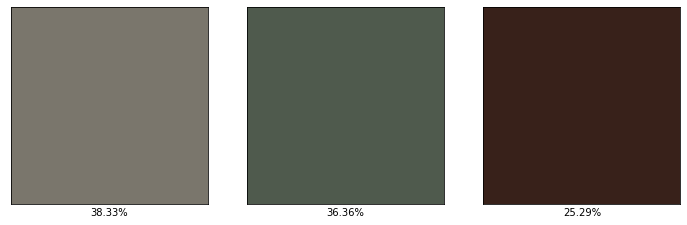

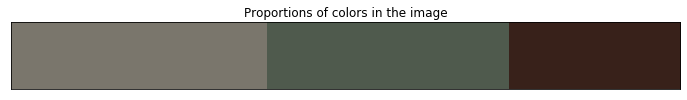

In [164]:
#jerseyColor.style.set_properties(**{'text-align': 'right'})
#jerseyColor3
#jerseyColor3.loc[:,'Jersey Color 1 RGB ']
jcrgb1 = jerseyColor3_n[['Jersey Color 1 RGB ']].to_numpy()
jcrgb2 = jerseyColor3_n[['Jersey Color 2 RGB ']].to_numpy()
jcrgb3 = jerseyColor3_n[['Jersey Color 3 RGB ']].to_numpy()

totColor1 = []
totColor2 = []
totColor3 = []

rows = jerseyColor3_n.shape[0] - 1
i = 0
clusters = 3
for i in range(rows):
    totColor1.append(jcrgb1[i][0])
    totColor1[i] = [totColor1[i][2],totColor1[i][1],totColor1[i][0]]
    totColor2.append(jcrgb2[i][0])
    totColor2[i] = [totColor2[i][2],totColor2[i][1],totColor2[i][0]]
    totColor3.append(jcrgb3[i][0])
    totColor3[i] = [totColor3[i][2],totColor3[i][1],totColor3[i][0]]
#print(totColor1)

kmeans1 = KMeans(n_clusters=clusters, init = 'k-means++', random_state=0, tol = 1e-4)
kmeans1.fit(totColor1)

kmeans2 = KMeans(n_clusters=clusters, random_state=0, tol = 1e-4)
kmeans2.fit(totColor2)

kmeans3 = KMeans(n_clusters=clusters, random_state=0, tol = 1e-4)
kmeans3.fit(totColor3)

#Define the array with centroids
dominant_colors1 = np.array(kmeans1.cluster_centers_,dtype='uint')
dominant_colors2 = np.array(kmeans2.cluster_centers_,dtype='uint')
dominant_colors3 = np.array(kmeans3.cluster_centers_,dtype='uint')
 #Calculate percentages 
percentages1 = (np.unique(kmeans1.labels_,return_counts=True)[1])/(rows+1)
percentages2 = (np.unique(kmeans2.labels_,return_counts=True)[1])/(rows+1)
percentages3 = (np.unique(kmeans3.labels_,return_counts=True)[1])/(rows+1)

pc1 = zip(percentages1,dominant_colors1)
pc1 = sorted(pc1,reverse=True)

pc2 = zip(percentages2,dominant_colors2)
pc2 = sorted(pc2,reverse=True)

pc3 = zip(percentages3,dominant_colors3)
pc3 = sorted(pc3,reverse=True)

print(dominant_colors1)
print(dominant_colors2)
print(dominant_colors3)

print(pc1)
print(pc2)
print(pc3)
block1 = np.ones((50,50,3),dtype='uint')
block2 = np.ones((50,50,3),dtype='uint')
block3 = np.ones((50,50,3),dtype='uint')
#Plotting utility
plt.figure(figsize=(12,8))
for i in range(clusters):
    plt.subplot(1,clusters,i+1)
    block1[:] = pc1[i][1][::-1] # we have done this to convert bgr(opencv) to rgb(matplotlib) 
    block2[:] = pc2[i][1][::-1]
    block3[:] = pc3[i][1][::-1]
    #print(block)
    plt.imshow(block1)
    plt.xticks([])
    plt.yticks([])
    plt.xlabel(str(round(pc1[i][0]*100,2))+'%')
    #plt.xlabel(str(round(pc2[i][0]*100,2))+'%')
    #plt.xlabel(str(round(pc3[i][0]*100,2))+'%')
bar1 = np.ones((50,500,3),dtype='uint')
bar2 = np.ones((50,500,3),dtype='uint')
bar3 = np.ones((50,500,3),dtype='uint')
plt.figure(figsize=(12,8))
plt.title('Proportions of colors in the image')

start = 0
i = 1
for p,c in pc1:
    #print(bar)
    end = start+int(p*bar1.shape[1])
    if i==clusters:
        bar1[:,start:] = c[::-1]
    else:
        bar1[:,start:end] = c[::-1]
    start = end
    i+=1

start = 0
i = 1
for p,c in pc2:
    #print(bar)
    end = start+int(p*bar2.shape[1])
    if i==clusters:
        bar2[:,start:] = c[::-1]
    else:
        bar2[:,start:end] = c[::-1]
    start = end
    i+=1

start = 0
i = 1
for p,c in pc3:
    #print(bar)
    end = start+int(p*bar3.shape[1])
    if i==clusters:
        bar3[:,start:] = c[::-1]
    else:
        bar3[:,start:end] = c[::-1]
    start = end
    i+=1
plt.imshow(bar1)
plt.xticks([])
plt.yticks([])

In [166]:
# Calling the trackbar GUI    
if __name__=="__main__":
    main(jerseyColor3)

0
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 62_BB0_Cropped.jpg
0
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 62_BB0_Cropped.jpg
0
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 62_BB0_Cropped.jpg
0
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 62_BB0_Cropped.jpg
0
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 62_BB0_Cropped.jpg
0
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 62_BB0_Cropped.jpg
0
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 62_BB0_Cropped.jpg
0
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 62_BB0_Cropped.jpg
0
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 62_BB0_Cropped.jpg
0
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 62_BB0_Cropped.jpg
0
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 62_BB0_Cropped.jpg
0
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 62_BB0_Crop

0
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 62_BB0_Cropped.jpg
0
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 62_BB0_Cropped.jpg
0
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 62_BB0_Cropped.jpg
0
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 62_BB0_Cropped.jpg
0
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 62_BB0_Cropped.jpg
0
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 62_BB0_Cropped.jpg
0
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 62_BB0_Cropped.jpg
0
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 62_BB0_Cropped.jpg
0
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 62_BB0_Cropped.jpg
0
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 62_BB0_Cropped.jpg
0
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 62_BB0_Cropped.jpg
0
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 62_BB0_Crop

0
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 62_BB0_Cropped.jpg
0
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 62_BB0_Cropped.jpg
0
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 62_BB0_Cropped.jpg
0
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 62_BB0_Cropped.jpg
0
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 62_BB0_Cropped.jpg
0
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 62_BB0_Cropped.jpg
0
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 62_BB0_Cropped.jpg
0
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 62_BB0_Cropped.jpg
0
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 62_BB0_Cropped.jpg
0
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 62_BB0_Cropped.jpg
0
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 62_BB0_Cropped.jpg
0
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 62_BB0_Crop

TypeError: emptyFunction() takes 0 positional arguments but 1 was given

361
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 956_BB10_Cropped.jpg
361
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 956_BB10_Cropped.jpg
361
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 956_BB10_Cropped.jpg
361
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 956_BB10_Cropped.jpg
361
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 956_BB10_Cropped.jpg
361
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 956_BB10_Cropped.jpg
361
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 956_BB10_Cropped.jpg
361
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 956_BB10_Cropped.jpg
361
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 956_BB10_Cropped.jpg
361
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 956_BB10_Cropped.jpg
361
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 956_BB10_Cropped.jpg
361
C:\Users\vmurc\Desktop\Trace

TypeError: emptyFunction() takes 0 positional arguments but 1 was given

722
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 1082_BB15_Cropped.jpg
722
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 1082_BB15_Cropped.jpg
722
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 1082_BB15_Cropped.jpg
722
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 1082_BB15_Cropped.jpg
722
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 1082_BB15_Cropped.jpg
722
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 1082_BB15_Cropped.jpg
722
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 1082_BB15_Cropped.jpg
722
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 1082_BB15_Cropped.jpg
722
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 1082_BB15_Cropped.jpg
722
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 1082_BB15_Cropped.jpg
722
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 1082_BB15_Cropped.jpg
722
C:\Users\vmurc\De

TypeError: emptyFunction() takes 0 positional arguments but 1 was given

1083
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 1214_BB9_Cropped.jpg
1083
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 1214_BB9_Cropped.jpg
1083
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 1214_BB9_Cropped.jpg
1083
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 1214_BB9_Cropped.jpg
1083
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 1214_BB9_Cropped.jpg
1083
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 1214_BB9_Cropped.jpg
1083
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 1214_BB9_Cropped.jpg
1083
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 1214_BB9_Cropped.jpg
1083
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 1214_BB9_Cropped.jpg
1083
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 1214_BB9_Cropped.jpg
1083
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 1214_BB9_Cropped.jpg
1083
C:\Users\vmurc\D

TypeError: emptyFunction() takes 0 positional arguments but 1 was given

722
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 1082_BB15_Cropped.jpg
722
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 1082_BB15_Cropped.jpg
722
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 1082_BB15_Cropped.jpg
722
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 1082_BB15_Cropped.jpg
722
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 1082_BB15_Cropped.jpg
722
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 1082_BB15_Cropped.jpg
722
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 1082_BB15_Cropped.jpg
722
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 1082_BB15_Cropped.jpg
722
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 1082_BB15_Cropped.jpg
722
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 1082_BB15_Cropped.jpg
722
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 1082_BB15_Cropped.jpg
722
C:\Users\vmurc\De

TypeError: emptyFunction() takes 0 positional arguments but 1 was given

1083
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 1214_BB9_Cropped.jpg
1083
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 1214_BB9_Cropped.jpg
1083
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 1214_BB9_Cropped.jpg
1083
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 1214_BB9_Cropped.jpg
1083
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 1214_BB9_Cropped.jpg
1083
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 1214_BB9_Cropped.jpg
1083
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 1214_BB9_Cropped.jpg
1083
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 1214_BB9_Cropped.jpg
1083
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 1214_BB9_Cropped.jpg
1083
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 1214_BB9_Cropped.jpg
1083
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 1214_BB9_Cropped.jpg
1083
C:\Users\vmurc\D

TypeError: emptyFunction() takes 0 positional arguments but 1 was given

1444
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 1478_BB5_Cropped.jpg
1444
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 1478_BB5_Cropped.jpg
1444
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 1478_BB5_Cropped.jpg
1444
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 1478_BB5_Cropped.jpg
1444
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 1478_BB5_Cropped.jpg
1444
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 1478_BB5_Cropped.jpg
1444
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 1478_BB5_Cropped.jpg
1444
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 1478_BB5_Cropped.jpg
1444
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 1478_BB5_Cropped.jpg
1444
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 1478_BB5_Cropped.jpg
1444
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 1478_BB5_Cropped.jpg
1444
C:\Users\vmurc\D

TypeError: emptyFunction() takes 0 positional arguments but 1 was given

1805
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 1694_BB11_Cropped.jpg
1805
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 1694_BB11_Cropped.jpg
1805
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 1694_BB11_Cropped.jpg
1805
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 1694_BB11_Cropped.jpg
1805
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 1694_BB11_Cropped.jpg
1805
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 1694_BB11_Cropped.jpg
1805
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 1694_BB11_Cropped.jpg
1805
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 1694_BB11_Cropped.jpg
1805
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 1694_BB11_Cropped.jpg
1805
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 1694_BB11_Cropped.jpg
1805
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 1694_BB11_Cropped.jpg
1805
C:\Us

TypeError: emptyFunction() takes 0 positional arguments but 1 was given

2166
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 1850_BB2_Cropped.jpg
2166
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 1850_BB2_Cropped.jpg
2166
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 1850_BB2_Cropped.jpg
2166
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 1850_BB2_Cropped.jpg
2166
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 1850_BB2_Cropped.jpg
2166
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 1850_BB2_Cropped.jpg
2166
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 1850_BB2_Cropped.jpg
2166
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 1850_BB2_Cropped.jpg
2166
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 1850_BB2_Cropped.jpg
2166
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 1850_BB2_Cropped.jpg
2166
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 1850_BB2_Cropped.jpg
2166
C:\Users\vmurc\D

TypeError: emptyFunction() takes 0 positional arguments but 1 was given

2527
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 1994_BB13_Cropped.jpg
2527
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 1994_BB13_Cropped.jpg
2527
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 1994_BB13_Cropped.jpg
2527
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 1994_BB13_Cropped.jpg
2527
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 1994_BB13_Cropped.jpg
2527
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 1994_BB13_Cropped.jpg
2527
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 1994_BB13_Cropped.jpg
2527
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 1994_BB13_Cropped.jpg
2527
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 1994_BB13_Cropped.jpg
2527
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 1994_BB13_Cropped.jpg
2527
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 1994_BB13_Cropped.jpg
2527
C:\Us

TypeError: emptyFunction() takes 0 positional arguments but 1 was given

2888
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 2150_BB11_Cropped.jpg
2888
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 2150_BB11_Cropped.jpg
2888
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 2150_BB11_Cropped.jpg
2888
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 2150_BB11_Cropped.jpg
2888
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 2150_BB11_Cropped.jpg
2888
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 2150_BB11_Cropped.jpg
2888
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 2150_BB11_Cropped.jpg
2888
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 2150_BB11_Cropped.jpg
2888
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 2150_BB11_Cropped.jpg
2888
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 2150_BB11_Cropped.jpg
2888
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 2150_BB11_Cropped.jpg
2888
C:\Us

TypeError: emptyFunction() takes 0 positional arguments but 1 was given

3249
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 2324_BB7_Cropped.jpg
3249
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 2324_BB7_Cropped.jpg
3249
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 2324_BB7_Cropped.jpg
3249
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 2324_BB7_Cropped.jpg
3249
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 2324_BB7_Cropped.jpg
3249
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 2324_BB7_Cropped.jpg
3249
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 2324_BB7_Cropped.jpg
3249
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 2324_BB7_Cropped.jpg
3249
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 2324_BB7_Cropped.jpg
3249
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 2324_BB7_Cropped.jpg
3249
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 2324_BB7_Cropped.jpg
3249
C:\Users\vmurc\D

TypeError: emptyFunction() takes 0 positional arguments but 1 was given

3610
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 2588_BB4_Cropped.jpg
3610
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 2588_BB4_Cropped.jpg
3610
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 2588_BB4_Cropped.jpg
3610
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 2588_BB4_Cropped.jpg
3610
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 2588_BB4_Cropped.jpg
3610
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 2588_BB4_Cropped.jpg
3610
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 2588_BB4_Cropped.jpg
3610
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 2588_BB4_Cropped.jpg
3610
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 2588_BB4_Cropped.jpg
3610
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 2588_BB4_Cropped.jpg
3610
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 2588_BB4_Cropped.jpg
3610
C:\Users\vmurc\D

TypeError: emptyFunction() takes 0 positional arguments but 1 was given

3971
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 2744_BB9_Cropped.jpg
3971
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 2744_BB9_Cropped.jpg
3971
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 2744_BB9_Cropped.jpg
3971
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 2744_BB9_Cropped.jpg
3971
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 2744_BB9_Cropped.jpg
3971
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 2744_BB9_Cropped.jpg
3971
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 2744_BB9_Cropped.jpg
3971
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 2744_BB9_Cropped.jpg
3971
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 2744_BB9_Cropped.jpg
3971
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 2744_BB9_Cropped.jpg
3971
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 2744_BB9_Cropped.jpg
3971
C:\Users\vmurc\D

TypeError: emptyFunction() takes 0 positional arguments but 1 was given

4332
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 2936_BB3_Cropped.jpg
4332
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 2936_BB3_Cropped.jpg
4332
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 2936_BB3_Cropped.jpg
4332
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 2936_BB3_Cropped.jpg
4332
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 2936_BB3_Cropped.jpg
4332
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 2936_BB3_Cropped.jpg
4332
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 2936_BB3_Cropped.jpg
4332
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 2936_BB3_Cropped.jpg
4332
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 2936_BB3_Cropped.jpg
4332
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 2936_BB3_Cropped.jpg
4332
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 2936_BB3_Cropped.jpg
4332
C:\Users\vmurc\D

TypeError: emptyFunction() takes 0 positional arguments but 1 was given

3971
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 2744_BB9_Cropped.jpg
3971
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 2744_BB9_Cropped.jpg
3971
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 2744_BB9_Cropped.jpg
3971
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 2744_BB9_Cropped.jpg
3971
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 2744_BB9_Cropped.jpg
3971
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 2744_BB9_Cropped.jpg
3971
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 2744_BB9_Cropped.jpg
3971
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 2744_BB9_Cropped.jpg
3971
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 2744_BB9_Cropped.jpg
3971
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 2744_BB9_Cropped.jpg
3971
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 2744_BB9_Cropped.jpg
3971
C:\Users\vmurc\D

TypeError: emptyFunction() takes 0 positional arguments but 1 was given

4332
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 2936_BB3_Cropped.jpg
4332
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 2936_BB3_Cropped.jpg
4332
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 2936_BB3_Cropped.jpg
4332
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 2936_BB3_Cropped.jpg
4332
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 2936_BB3_Cropped.jpg
4332
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 2936_BB3_Cropped.jpg
4332
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 2936_BB3_Cropped.jpg
4332
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 2936_BB3_Cropped.jpg
4332
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 2936_BB3_Cropped.jpg
4332
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 2936_BB3_Cropped.jpg
4332
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 2936_BB3_Cropped.jpg
4332
C:\Users\vmurc\D

TypeError: emptyFunction() takes 0 positional arguments but 1 was given

3971
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 2744_BB9_Cropped.jpg
3971
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 2744_BB9_Cropped.jpg
3971
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 2744_BB9_Cropped.jpg
3971
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 2744_BB9_Cropped.jpg
3971
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 2744_BB9_Cropped.jpg
3971
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 2744_BB9_Cropped.jpg
3971
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 2744_BB9_Cropped.jpg
3971
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 2744_BB9_Cropped.jpg
3971
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 2744_BB9_Cropped.jpg
3971
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 2744_BB9_Cropped.jpg
3971
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 2744_BB9_Cropped.jpg
3971
C:\Users\vmurc\D

3971
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 2744_BB9_Cropped.jpg
3971
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 2744_BB9_Cropped.jpg
3971
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 2744_BB9_Cropped.jpg
3971
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 2744_BB9_Cropped.jpg
3971
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 2744_BB9_Cropped.jpg
3971
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 2744_BB9_Cropped.jpg
3971
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 2744_BB9_Cropped.jpg
3971
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 2744_BB9_Cropped.jpg
3971
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 2744_BB9_Cropped.jpg
3971
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 2744_BB9_Cropped.jpg
3971
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 2744_BB9_Cropped.jpg
3971
C:\Users\vmurc\D

3971
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 2744_BB9_Cropped.jpg
3971
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 2744_BB9_Cropped.jpg
3971
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 2744_BB9_Cropped.jpg
3971
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 2744_BB9_Cropped.jpg
3971
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 2744_BB9_Cropped.jpg
3971
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 2744_BB9_Cropped.jpg
3971
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 2744_BB9_Cropped.jpg
3971
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 2744_BB9_Cropped.jpg
3971
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 2744_BB9_Cropped.jpg
3971
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 2744_BB9_Cropped.jpg
3971
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 2744_BB9_Cropped.jpg
3971
C:\Users\vmurc\D

3971
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 2744_BB9_Cropped.jpg
3971
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 2744_BB9_Cropped.jpg
3971
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 2744_BB9_Cropped.jpg
3971
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 2744_BB9_Cropped.jpg
3971
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 2744_BB9_Cropped.jpg
3971
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 2744_BB9_Cropped.jpg
3971
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 2744_BB9_Cropped.jpg
3971
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 2744_BB9_Cropped.jpg
3971
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 2744_BB9_Cropped.jpg
3971
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 2744_BB9_Cropped.jpg
3971
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 2744_BB9_Cropped.jpg
3971
C:\Users\vmurc\D

TypeError: emptyFunction() takes 0 positional arguments but 1 was given

4332
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 2936_BB3_Cropped.jpg
4332
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 2936_BB3_Cropped.jpg
4332
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 2936_BB3_Cropped.jpg
4332
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 2936_BB3_Cropped.jpg
4332
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 2936_BB3_Cropped.jpg
4332
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 2936_BB3_Cropped.jpg
4332
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 2936_BB3_Cropped.jpg
4332
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 2936_BB3_Cropped.jpg
4332
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 2936_BB3_Cropped.jpg
4332
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 2936_BB3_Cropped.jpg
4332
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 2936_BB3_Cropped.jpg
4332
C:\Users\vmurc\D

TypeError: emptyFunction() takes 0 positional arguments but 1 was given

4693
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 3128_BB13_Cropped.jpg
4693
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 3128_BB13_Cropped.jpg
4693
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 3128_BB13_Cropped.jpg
4693
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 3128_BB13_Cropped.jpg
4693
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 3128_BB13_Cropped.jpg
4693
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 3128_BB13_Cropped.jpg
4693
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 3128_BB13_Cropped.jpg
4693
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 3128_BB13_Cropped.jpg
4693
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 3128_BB13_Cropped.jpg
4693
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 3128_BB13_Cropped.jpg
4693
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 3128_BB13_Cropped.jpg
4693
C:\Us

TypeError: emptyFunction() takes 0 positional arguments but 1 was given

5054
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 3260_BB17_Cropped.jpg
5054
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 3260_BB17_Cropped.jpg
5054
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 3260_BB17_Cropped.jpg
5054
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 3260_BB17_Cropped.jpg
5054
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 3260_BB17_Cropped.jpg
5054
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 3260_BB17_Cropped.jpg
5054
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 3260_BB17_Cropped.jpg
5054
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 3260_BB17_Cropped.jpg
5054
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 3260_BB17_Cropped.jpg
5054
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 3260_BB17_Cropped.jpg
5054
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 3260_BB17_Cropped.jpg
5054
C:\Us

TypeError: emptyFunction() takes 0 positional arguments but 1 was given

5415
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 3368_BB5_Cropped.jpg
5415
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 3368_BB5_Cropped.jpg
5415
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 3368_BB5_Cropped.jpg
5415
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 3368_BB5_Cropped.jpg
5415
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 3368_BB5_Cropped.jpg
5415
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 3368_BB5_Cropped.jpg
5415
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 3368_BB5_Cropped.jpg
5415
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 3368_BB5_Cropped.jpg
5415
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 3368_BB5_Cropped.jpg
5415
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 3368_BB5_Cropped.jpg
5415
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 3368_BB5_Cropped.jpg
5415
C:\Users\vmurc\D

TypeError: emptyFunction() takes 0 positional arguments but 1 was given

5776
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 3458_BB18_Cropped.jpg
5776
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 3458_BB18_Cropped.jpg
5776
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 3458_BB18_Cropped.jpg
5776
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 3458_BB18_Cropped.jpg
5776
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 3458_BB18_Cropped.jpg
5776
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 3458_BB18_Cropped.jpg
5776
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 3458_BB18_Cropped.jpg
5776
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 3458_BB18_Cropped.jpg
5776
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 3458_BB18_Cropped.jpg
5776
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 3458_BB18_Cropped.jpg
5776
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 3458_BB18_Cropped.jpg
5776
C:\Us

TypeError: emptyFunction() takes 0 positional arguments but 1 was given

6137
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 3554_BB7_Cropped.jpg
6137
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 3554_BB7_Cropped.jpg
6137
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 3554_BB7_Cropped.jpg
6137
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 3554_BB7_Cropped.jpg
6137
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 3554_BB7_Cropped.jpg
6137
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 3554_BB7_Cropped.jpg
6137
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 3554_BB7_Cropped.jpg
6137
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 3554_BB7_Cropped.jpg
6137
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 3554_BB7_Cropped.jpg
6137
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 3554_BB7_Cropped.jpg
6137
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 3554_BB7_Cropped.jpg
6137
C:\Users\vmurc\D

TypeError: emptyFunction() takes 0 positional arguments but 1 was given

6498
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 3650_BB17_Cropped.jpg
6498
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 3650_BB17_Cropped.jpg
6498
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 3650_BB17_Cropped.jpg
6498
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 3650_BB17_Cropped.jpg
6498
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 3650_BB17_Cropped.jpg
6498
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 3650_BB17_Cropped.jpg
6498
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 3650_BB17_Cropped.jpg
6498
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 3650_BB17_Cropped.jpg
6498
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 3650_BB17_Cropped.jpg
6498
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 3650_BB17_Cropped.jpg
6498
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 3650_BB17_Cropped.jpg
6498
C:\Us

TypeError: emptyFunction() takes 0 positional arguments but 1 was given

6859
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 3752_BB22_Cropped.jpg
6859
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 3752_BB22_Cropped.jpg
6859
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 3752_BB22_Cropped.jpg
6859
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 3752_BB22_Cropped.jpg
6859
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 3752_BB22_Cropped.jpg
6859
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 3752_BB22_Cropped.jpg
6859
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 3752_BB22_Cropped.jpg
6859
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 3752_BB22_Cropped.jpg
6859
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 3752_BB22_Cropped.jpg
6859
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 3752_BB22_Cropped.jpg
6859
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 3752_BB22_Cropped.jpg
6859
C:\Us

TypeError: emptyFunction() takes 0 positional arguments but 1 was given

7220
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 3848_BB14_Cropped.jpg
7220
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 3848_BB14_Cropped.jpg
7220
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 3848_BB14_Cropped.jpg
7220
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 3848_BB14_Cropped.jpg
7220
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 3848_BB14_Cropped.jpg
7220
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 3848_BB14_Cropped.jpg
7220
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 3848_BB14_Cropped.jpg
7220
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 3848_BB14_Cropped.jpg
7220
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 3848_BB14_Cropped.jpg
7220
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 3848_BB14_Cropped.jpg
7220
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 3848_BB14_Cropped.jpg
7220
C:\Us

TypeError: emptyFunction() takes 0 positional arguments but 1 was given

7581
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 3944_BB22_Cropped.jpg
7581
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 3944_BB22_Cropped.jpg
7581
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 3944_BB22_Cropped.jpg
7581
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 3944_BB22_Cropped.jpg
7581
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 3944_BB22_Cropped.jpg
7581
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 3944_BB22_Cropped.jpg
7581
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 3944_BB22_Cropped.jpg
7581
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 3944_BB22_Cropped.jpg
7581
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 3944_BB22_Cropped.jpg
7581
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 3944_BB22_Cropped.jpg
7581
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 3944_BB22_Cropped.jpg
7581
C:\Us

TypeError: emptyFunction() takes 0 positional arguments but 1 was given

7942
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 4040_BB6_Cropped.jpg
7942
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 4040_BB6_Cropped.jpg
7942
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 4040_BB6_Cropped.jpg
7942
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 4040_BB6_Cropped.jpg
7942
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 4040_BB6_Cropped.jpg
7942
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 4040_BB6_Cropped.jpg
7942
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 4040_BB6_Cropped.jpg
7942
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 4040_BB6_Cropped.jpg
7942
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 4040_BB6_Cropped.jpg
7942
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 4040_BB6_Cropped.jpg
7942
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 4040_BB6_Cropped.jpg
7942
C:\Users\vmurc\D

TypeError: emptyFunction() takes 0 positional arguments but 1 was given

8303
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 4124_BB19_Cropped.jpg
8303
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 4124_BB19_Cropped.jpg
8303
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 4124_BB19_Cropped.jpg
8303
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 4124_BB19_Cropped.jpg
8303
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 4124_BB19_Cropped.jpg
8303
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 4124_BB19_Cropped.jpg
8303
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 4124_BB19_Cropped.jpg
8303
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 4124_BB19_Cropped.jpg
8303
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 4124_BB19_Cropped.jpg
8303
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 4124_BB19_Cropped.jpg
8303
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 4124_BB19_Cropped.jpg
8303
C:\Us

TypeError: emptyFunction() takes 0 positional arguments but 1 was given

7942
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 4040_BB6_Cropped.jpg
7942
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 4040_BB6_Cropped.jpg
7942
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 4040_BB6_Cropped.jpg
7942
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 4040_BB6_Cropped.jpg
7942
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 4040_BB6_Cropped.jpg
7942
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 4040_BB6_Cropped.jpg


TypeError: emptyFunction() takes 0 positional arguments but 1 was given

7581
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 3944_BB22_Cropped.jpg
7581
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 3944_BB22_Cropped.jpg
7581
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 3944_BB22_Cropped.jpg
7581
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 3944_BB22_Cropped.jpg


TypeError: emptyFunction() takes 0 positional arguments but 1 was given

7220
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 3848_BB14_Cropped.jpg
7220
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 3848_BB14_Cropped.jpg
7220
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 3848_BB14_Cropped.jpg
7220
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 3848_BB14_Cropped.jpg
7220
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 3848_BB14_Cropped.jpg
7220
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 3848_BB14_Cropped.jpg
7220
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 3848_BB14_Cropped.jpg
7220
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 3848_BB14_Cropped.jpg
7220
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 3848_BB14_Cropped.jpg
7220
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 3848_BB14_Cropped.jpg
7220
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 3848_BB14_Cropped.jpg
7220
C:\Us

TypeError: emptyFunction() takes 0 positional arguments but 1 was given

6859
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 3752_BB22_Cropped.jpg
6859
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 3752_BB22_Cropped.jpg


TypeError: emptyFunction() takes 0 positional arguments but 1 was given

6498
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 3650_BB17_Cropped.jpg
6498
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 3650_BB17_Cropped.jpg


TypeError: emptyFunction() takes 0 positional arguments but 1 was given

6137
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 3554_BB7_Cropped.jpg
6137
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 3554_BB7_Cropped.jpg
6137
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 3554_BB7_Cropped.jpg
6137
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 3554_BB7_Cropped.jpg
6137
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 3554_BB7_Cropped.jpg
6137
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 3554_BB7_Cropped.jpg
6137
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 3554_BB7_Cropped.jpg
6137
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 3554_BB7_Cropped.jpg
6137
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 3554_BB7_Cropped.jpg
6137
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 3554_BB7_Cropped.jpg
6137
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 3554_BB7_Cropped.jpg
6137
C:\Users\vmurc\D

TypeError: emptyFunction() takes 0 positional arguments but 1 was given

5776
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 3458_BB18_Cropped.jpg


TypeError: emptyFunction() takes 0 positional arguments but 1 was given

5415
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 3368_BB5_Cropped.jpg
5415
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 3368_BB5_Cropped.jpg
5415
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 3368_BB5_Cropped.jpg


TypeError: emptyFunction() takes 0 positional arguments but 1 was given

5054
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 3260_BB17_Cropped.jpg
5054
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 3260_BB17_Cropped.jpg
5054
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 3260_BB17_Cropped.jpg
5054
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 3260_BB17_Cropped.jpg
5054
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 3260_BB17_Cropped.jpg
5054
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 3260_BB17_Cropped.jpg
5054
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 3260_BB17_Cropped.jpg
5054
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 3260_BB17_Cropped.jpg
5054
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 3260_BB17_Cropped.jpg
5054
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 3260_BB17_Cropped.jpg
5054
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 3260_BB17_Cropped.jpg
5054
C:\Us

TypeError: emptyFunction() takes 0 positional arguments but 1 was given

4693
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 3128_BB13_Cropped.jpg
4693
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 3128_BB13_Cropped.jpg


TypeError: emptyFunction() takes 0 positional arguments but 1 was given

4332
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 2936_BB3_Cropped.jpg


TypeError: emptyFunction() takes 0 positional arguments but 1 was given

3971
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 2744_BB9_Cropped.jpg
3971
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 2744_BB9_Cropped.jpg
3971
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 2744_BB9_Cropped.jpg


TypeError: emptyFunction() takes 0 positional arguments but 1 was given

3610
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 2588_BB4_Cropped.jpg
3610
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 2588_BB4_Cropped.jpg
3610
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 2588_BB4_Cropped.jpg
3610
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 2588_BB4_Cropped.jpg
3610
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 2588_BB4_Cropped.jpg
3610
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 2588_BB4_Cropped.jpg
3610
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 2588_BB4_Cropped.jpg
3610
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 2588_BB4_Cropped.jpg
3610
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 2588_BB4_Cropped.jpg
3610
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 2588_BB4_Cropped.jpg
3610
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 2588_BB4_Cropped.jpg
3610
C:\Users\vmurc\D

TypeError: emptyFunction() takes 0 positional arguments but 1 was given

3249
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 2324_BB7_Cropped.jpg
3249
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 2324_BB7_Cropped.jpg


TypeError: emptyFunction() takes 0 positional arguments but 1 was given

2888
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 2150_BB11_Cropped.jpg
2888
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 2150_BB11_Cropped.jpg


TypeError: emptyFunction() takes 0 positional arguments but 1 was given

2527
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 1994_BB13_Cropped.jpg
2527
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 1994_BB13_Cropped.jpg
2527
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 1994_BB13_Cropped.jpg
2527
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 1994_BB13_Cropped.jpg
2527
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 1994_BB13_Cropped.jpg
2527
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 1994_BB13_Cropped.jpg


TypeError: emptyFunction() takes 0 positional arguments but 1 was given

2166
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 1850_BB2_Cropped.jpg
2166
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 1850_BB2_Cropped.jpg
2166
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 1850_BB2_Cropped.jpg
2166
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 1850_BB2_Cropped.jpg
2166
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 1850_BB2_Cropped.jpg
2166
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 1850_BB2_Cropped.jpg
2166
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 1850_BB2_Cropped.jpg
2166
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 1850_BB2_Cropped.jpg
2166
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 1850_BB2_Cropped.jpg
2166
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 1850_BB2_Cropped.jpg
2166
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 1850_BB2_Cropped.jpg
2166
C:\Users\vmurc\D

TypeError: emptyFunction() takes 0 positional arguments but 1 was given

1805
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 1694_BB11_Cropped.jpg


TypeError: emptyFunction() takes 0 positional arguments but 1 was given

1444
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 1478_BB5_Cropped.jpg


TypeError: emptyFunction() takes 0 positional arguments but 1 was given

1083
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 1214_BB9_Cropped.jpg
1083
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 1214_BB9_Cropped.jpg


TypeError: emptyFunction() takes 0 positional arguments but 1 was given

722
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 1082_BB15_Cropped.jpg
722
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 1082_BB15_Cropped.jpg
722
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 1082_BB15_Cropped.jpg
722
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 1082_BB15_Cropped.jpg
722
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 1082_BB15_Cropped.jpg
722
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 1082_BB15_Cropped.jpg
722
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 1082_BB15_Cropped.jpg
722
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 1082_BB15_Cropped.jpg
722
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 1082_BB15_Cropped.jpg
722
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 1082_BB15_Cropped.jpg
722
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 1082_BB15_Cropped.jpg
722
C:\Users\vmurc\De

TypeError: emptyFunction() takes 0 positional arguments but 1 was given

361
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 956_BB10_Cropped.jpg
361
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 956_BB10_Cropped.jpg


TypeError: emptyFunction() takes 0 positional arguments but 1 was given

0
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 62_BB0_Cropped.jpg
0
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 62_BB0_Cropped.jpg
0
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 62_BB0_Cropped.jpg
0
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 62_BB0_Cropped.jpg
0
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 62_BB0_Cropped.jpg
0
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 62_BB0_Cropped.jpg
0
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 62_BB0_Cropped.jpg
0
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 62_BB0_Cropped.jpg
0
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 62_BB0_Cropped.jpg
0
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 62_BB0_Cropped.jpg
0
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 62_BB0_Cropped.jpg
0
C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 62_BB0_Crop

error: OpenCV(4.5.5) D:\a\opencv-python\opencv-python\opencv\modules\highgui\src\window_w32.cpp:2581: error: (-27:Null pointer) NULL window: 'Open CV Color Palette' in function 'cvGetTrackbarPos'


In [77]:
jerseyColor3

,File Name,Jersey Color 1,Jersey Color 1 RGB,Jersey Color 2,Jersey Color 2 RGB,Jersey Color 3,Jersey Color 3 RGB,Frame ID,Bounding Box ID
0,C:\Users\vmurc\Desktop\TraceInterview Project\...,#315a38,"[49, 90, 56]",#6a715a,"[106, 113, 90]",#aaac9d,"[170, 172, 157]",62,0
1,C:\Users\vmurc\Desktop\TraceInterview Project\...,#265e2c,"[38, 94, 44]",#70715a,"[112, 113, 90]",#406d43,"[64, 109, 67]",68,0
2,C:\Users\vmurc\Desktop\TraceInterview Project\...,#3c0d0b,"[60, 13, 11]",#564732,"[86, 71, 50]",#0e0908,"[14, 9, 8]",68,1
3,C:\Users\vmurc\Desktop\TraceInterview Project\...,#5d695c,"[93, 105, 92]",#91968e,"[145, 150, 142]",#206133,"[32, 97, 51]",92,0
4,C:\Users\vmurc\Desktop\TraceInterview Project\...,#6d7476,"[109, 116, 118]",#444a4f,"[68, 74, 79]",#bdbdc4,"[189, 189, 196]",92,1
...,...,...,...,...,...,...,...,...,...
18077,C:\Users\vmurc\Desktop\TraceInterview Project\...,#2c0e0b,"[44, 14, 11]",#6e5f50,"[110, 95, 80]",#493126,"[73, 49, 38]",7226,9
18078,C:\Users\vmurc\Desktop\TraceInterview Project\...,#6f6e29,"[111, 110, 41]",#a59f5d,"[165, 159, 93]",#dedb78,"[222, 219, 120]",7226,10
18079,C:\Users\vmurc\Desktop\TraceInterview Project\...,#898461,"[137, 132, 97]",#745844,"[116, 88, 68]",#4f2e1f,"[79, 46, 31]",7226,11
18080,C:\Users\vmurc\Desktop\TraceInterview Project\...,#53322a,"[83, 50, 42]",#785248,"[120, 82, 72]",#33150c,"[51, 21, 12]",7226,12


In [ ]:
path2img  =  r'C:\Users\vmurc\Desktop\TraceInterview Project\Raw_BB\Frame 104_BB1.jpg'
output_loc =  r'C:\Users\vmurc\Desktop\TraceInterview Project'

low_green = np.array([25, 52, 72])
high_green = np.array([102, 255, 255])


remove_nonplayer_region(path2img)

In [ ]:
#mMake video with bounding boxes
path2Frames_wBB =  r'C:\Users\vmurc\Desktop\TraceInterview Project\Frames_wBBs'
output_loc =  r'C:\Users\vmurc\Desktop\TraceInterview Project'
images = [img for img in os.listdir(path2Frames_wBB) if img.endswith(".jpg")]
frame = cv2.imread(os.path.join(path2Frames_wBB, images[0]))
height, width, layers = frame.shape

video = cv2.VideoWriter(output_loc + '\\video.avi',0,1,(width,height))

for image in images:
    video.write(cv2.imread(os.path.join(path2Frames_wBB, image)))

cv2.destroyAllWindows()
video.release()

In [ ]:
#Video wrapper function
#1 Define path to mp4,json files and define path to save the data to
path2mp4           =  r'C:\Users\vmurc\Downloads\Downloads\game_1779\LCamera\video_CAMB_CAMCAMBA_20180727_133419_001.mp4'
path2json          =  r'C:\Users\vmurc\Downloads\Downloads\game_1779\object_detector\video_CAMB_CAMCAMBA_20180727_133419_001.MP4.json'
output_loc         =  r'C:\Users\vmurc\Desktop\TraceInterview Project'
path2Frames        =  r'C:\Users\vmurc\Desktop\TraceInterview Project\RawFrames'
path2Frames_wBB    =  r'C:\Users\vmurc\Desktop\TraceInterview Project\Frames_wBBs'
path2RawBB         =  r'C:\Users\vmurc\Desktop\TraceInterview Project\Raw_BB'
path2MaskBB        =  r'C:\Users\vmurc\Desktop\TraceInterview Project\Masked_BB'
path2CroppedBB     =  r'C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB'
path2CroppedNoBG   =  r'C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BG_Removed'
nClusters = 2
getPlayerJerseyColorTrace(path2mp4,path2json,output_loc,nClusters,path2CroppedBB) 


In [156]:
path2img  =  r'C:\Users\vmurc\Desktop\TraceInterview Project\Cropped_BB\Frame 1100_BB5_Cropped.jpg'
path2MaskBB        =  r'C:\Users\vmurc\Desktop\TraceInterview Project\Masked_BB'
whichFrame = 1100
whichBB = 5
img = cv2.imread(path2img)

test = KMeansTrace(path2img,clusters,whichFrame,whichBB)
masked = cv2.imread(path2MaskBB + '\\Frame ' + str(whichFrame) + '_BB' + str(whichBB)+ '.jpg')
# display the image in a window
cv2.imshow('Original', img)
#cv2.imshow('edged', edged)
cv2.imshow('Cropped', masked)
# escape condition
cv2.waitKey(0)
# clean up windows
cv2.destroyAllWindows()